In [1]:
from IPython.display import display

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn

from scipy.fft import fft
from scipy.stats import skew, kurtosis
from scipy import signal

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from utils import *

from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('exp_230723_19_49.csv')

In [3]:
df.head(2)

,time,data1,data2,stim,target_id,target,data1_decoded,data2_decoded
0,23-07-23 19:44:24.020698,2.0,356,0,0,pedra,0.001173,0.208798
1,23-07-23 19:44:24.020698,602.0,349,0,0,pedra,0.353079,0.204692


In [4]:
df['time'] = pd.to_datetime(df.time)

In [5]:
df.shape

(80629, 8)

***
### EDA

***

In [6]:
df[['data1', 'data1_decoded', 'data2', 'data2_decoded']].describe()

,data1,data1_decoded,data2,data2_decoded
count,80621.000000,80621.000000,80629.000000,80629.000000
mean,625.246611,0.366714,533.851009,0.313109
std,88.234627,0.051751,88.185986,0.051722
min,2.000000,0.001173,57.000000,0.033431
25%,565.000000,0.331378,464.000000,0.272141
50%,605.000000,0.354839,513.000000,0.300880
75%,662.000000,0.388270,586.000000,0.343695
max,1023.000000,0.600000,963.000000,0.564809


In [7]:
# Quantidade de dados por target
df.target.value_counts()

target
pedra       21631
papel       19669
relaxado    19667
tesoura     19662
Name: count, dtype: int64

<AxesSubplot: xlabel='index'>

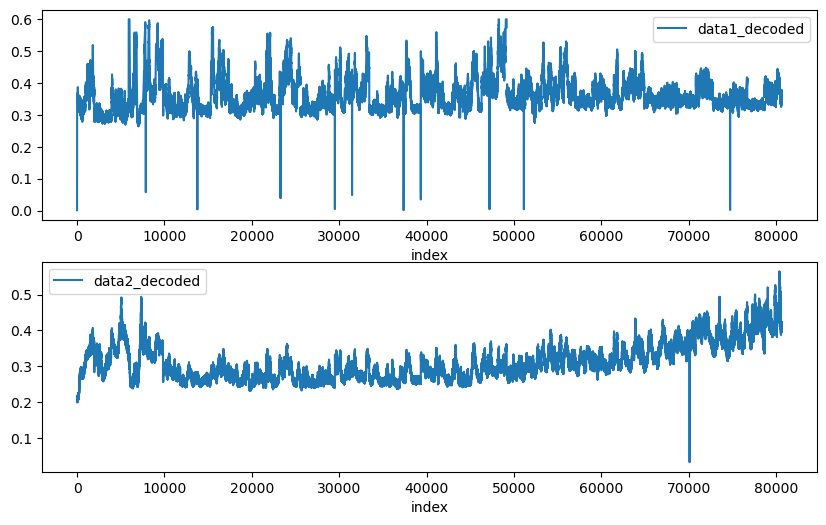

In [8]:
fig, ax = plt.subplots(figsize=(10,6), nrows=2)

df.reset_index().plot(
    kind='line',
    x='index',
    y='data1_decoded',
    ax=ax[0]
)

df.reset_index().plot(
    kind='line',
    x='index',
    y='data2_decoded',
    ax=ax[1]
)

(80609, 8)


<AxesSubplot: xlabel='index'>

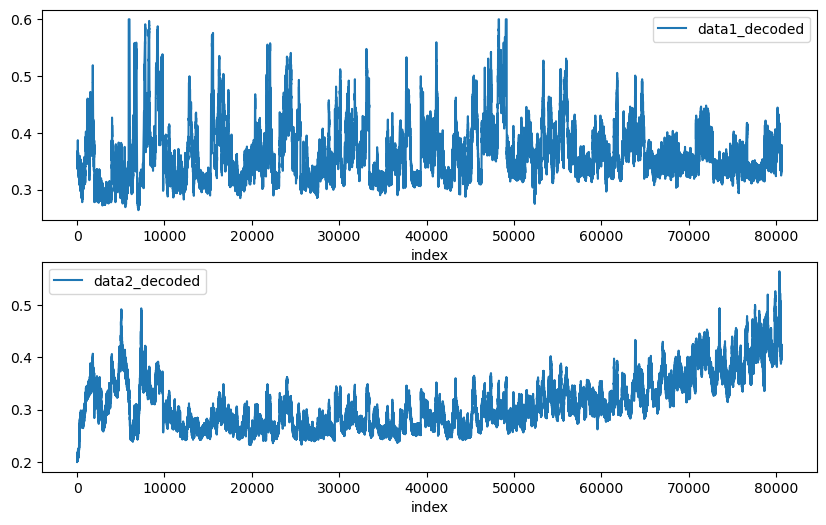

In [9]:
fig, ax = plt.subplots(figsize=(10,6), nrows=2)

df_ = df.copy()
df_ = df_[(df_.data1_decoded >= 0.1)&(df_.data2_decoded >= 0.1)]

print(df_.shape)

df_.reset_index().plot(
    kind='line',
    x='index',
    y='data1_decoded',
    ax=ax[0]
)

df_.reset_index().plot(
    kind='line',
    x='index',
    y='data2_decoded',
    ax=ax[1]
)

<AxesSubplot: xlabel='stim'>

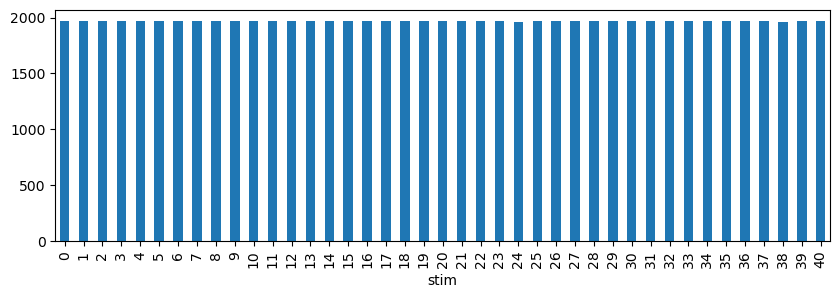

In [10]:
# Quantidade de dados por estímulo
df.groupby('stim').data1.count().plot.bar(figsize=(10,3))

#### Obs.

 - Apartir do stim 19 ta meio zuado não?

***

### Data Cleaning and Processing

***

In [11]:
df_ = df[(df.data1_decoded >= 0.1)&(df.data2_decoded >= 0.1)
#          &(df.stim <= 18)
        ].copy()
print(df.shape)
print(df_.shape) # Removendo casos estranhos, aparentemente não são muitos

df = df_.copy()

(80629, 8)
(80609, 8)


In [12]:
sample_rate = int(df.groupby('stim').data1.count().median() / 3) # qtd. de medições div. tempo de estímulo (3s)
sample_rate

655

In [14]:
# Filtrando freqs. bandpass 20hz - 150hz
df['data1_filtered'] = filter_band(
    df.data1_decoded,
    20,
    150,
    btype='bandpass',
    sampling_rate=sample_rate,
    order=4)

df['data2_filtered'] = filter_band(
    df.data2_decoded,
    20,
    150,
    btype='bandpass',
    sampling_rate=sample_rate,
    order=4)

# Filtrando freqs. bandstop 60hz
df['data1_filtered'] = filter_band(
    df.data1_decoded,
    58,
    62,
    btype='bandstop',
    sampling_rate=sample_rate,
    order=4)

df['data2_filtered'] = filter_band(
    df.data2_decoded,
    58,
    62,
    btype='bandstop',
    sampling_rate=sample_rate,
    order=4)

<AxesSubplot: >

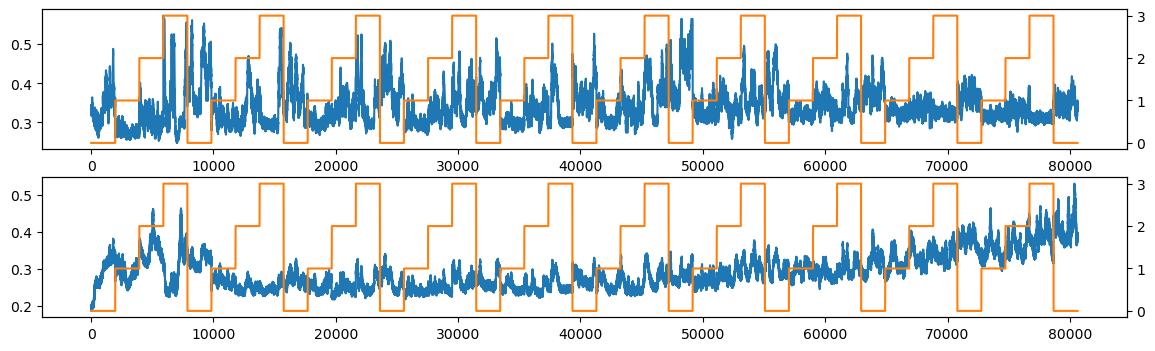

In [15]:
# Plot sinal e target_id
fig, ax = plt.subplots(figsize=(14,4), nrows=2)

df['data1_filtered'].plot(ax=ax[0])
df['target_id'].plot(secondary_y=True, ax=ax[0])

df['data2_filtered'].plot(ax=ax[1])
df['target_id'].plot(secondary_y=True, ax=ax[1])

In [16]:
df.data2_filtered.describe()

count    80609.000000
mean         0.294361
std          0.048626
min          0.187266
25%          0.255936
50%          0.283023
75%          0.323176
max          0.531138
Name: data2_filtered, dtype: float64

#### Feature eng. and ML


In [17]:
df.target_id.value_counts()

target_id
0    21625
1    19666
3    19660
2    19658
Name: count, dtype: int64

In [18]:
df_processed = df.copy()
janela = '.2'

# Processa canal1
df_processed1 = df_processed.groupby(['target_id', pd.Grouper(key='time', freq=f'{janela}S')
                  ]).data1_filtered.apply(lambda x: featureExtraction(x, 'data1')).reset_index().drop(columns=['level_2']).copy()
# Processa canal2
df_processed2 = df_processed.groupby(['target_id', pd.Grouper(key='time', freq=f'{janela}S')
                  ]).data2_filtered.apply(lambda x: featureExtraction(x, 'data2')).reset_index().drop(columns=['level_2']).copy()
# Concatena
df_processed = df_processed1.merge(df_processed2).copy()

# Novas Features
# df_processed['subst_int'] = df_processed['sum_square_data1'] - df_processed['sum_square_data2']
# df_processed['square_int'] = df_processed['sum_square_data1'] * df_processed['sum_square_data2']

display(df_processed.head(4))

,target_id,time,sum_square_data1,max_data1,min_data1,amplitude_data1,var_data1,rms_data1,zero_crossing_rate_data1,higher_order_moments_data1,sum_square_data2,max_data2,min_data2,amplitude_data2,var_data2,rms_data2,zero_crossing_rate_data2,higher_order_moments_data2
0,0,2023-07-23 19:44:24.000,0.011610,0.031993,-0.016474,0.048467,0.000099,0.009962,0.162393,0.988836,0.002980,0.012566,-0.010368,0.022934,0.000025,0.005047,0.179487,0.270964
1,0,2023-07-23 19:44:24.200,0.014034,0.021988,-0.028665,0.050653,0.000107,0.010350,0.145038,-0.374188,0.007745,0.022000,-0.012026,0.034026,0.000059,0.007689,0.152672,0.867103
2,0,2023-07-23 19:44:24.400,0.014118,0.030389,-0.024855,0.055244,0.000108,0.010381,0.190840,0.147468,0.019527,0.019502,-0.032634,0.052135,0.000149,0.012209,0.129771,-0.609472
3,0,2023-07-23 19:44:24.600,0.024019,0.032283,-0.032268,0.064552,0.000182,0.013489,0.151515,0.058343,0.005065,0.014870,-0.013632,0.028502,0.000038,0.006194,0.257576,0.011552


In [19]:
# df_processed.loc[df_processed.target_id == 1, 'target_id'] = 2 # Aparentemente papel e tesoura são iguais kkkk

In [97]:
# features= ['sum', 'max', 'min', 'amplitude', 'var', 'rms',
#            'mean_frequency', 'zero_crossing_rate', 'higher_order_moments'] # Features disponíveis
# features= ['sum', 'amplitude', 'rms', 'zero_crossing_rate']
features = [x for x in 
            df_processed.drop(columns=['time', 'target_id']).columns
           if (True)
            and(x.find('min_')==-1)
#             and(x.find('max_')==-1)
#             and(x.find('var_')==-1)
#             and(x.find('amplitude_')==-1)
#             and(x.find('zero_')==-1)
#             and(x.find('higher')==-1)
           ]

features

['sum_square_data1',
 'max_data1',
 'amplitude_data1',
 'var_data1',
 'rms_data1',
 'zero_crossing_rate_data1',
 'higher_order_moments_data1',
 'sum_square_data2',
 'max_data2',
 'amplitude_data2',
 'var_data2',
 'rms_data2',
 'zero_crossing_rate_data2',
 'higher_order_moments_data2']

In [146]:
pipe = Pipeline([
    ('std', StandardScaler()),
    ('clf', LinearDiscriminantAnalysis())
])

In [177]:
train, test = train_test_split(
    df_processed[df_processed.target_id!=3].copy(), 
    test_size=0.2,
    shuffle=True
)

In [178]:
pipe.fit(train[features].fillna(-1), train['target_id'])

Pipeline(steps=[('std', StandardScaler()),
                ('clf', LinearDiscriminantAnalysis())])

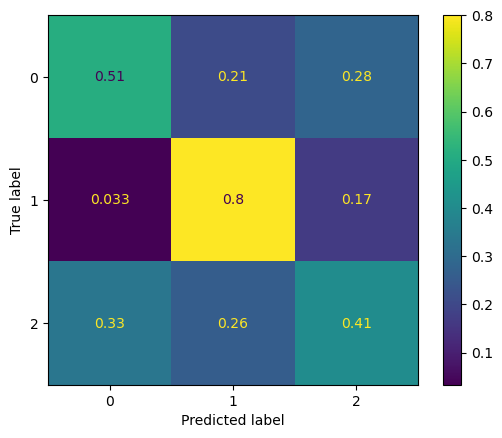

In [179]:
preds = pipe.predict(test[features].fillna(-1))

plot_confusion_matrix(
    pipe,
    X=test[features].fillna(-1),
    y_true=test['target_id'],
    normalize='true')

In [180]:
print(
    classification_report(y_pred=preds, y_true=test['target_id'])
)

              precision    recall  f1-score   support

           0       0.69      0.51      0.59        43
           1       0.60      0.80      0.69        30
           2       0.39      0.41      0.40        27

    accuracy                           0.57       100
   macro avg       0.56      0.57      0.56       100
weighted avg       0.58      0.57      0.57       100



In [181]:
probas = pipe.predict_proba(test[features].fillna(-1))

In [182]:
(probas[:4], test['target_id'][:4])

(array([[0.15582806, 0.59927485, 0.24489709],
        [0.42487851, 0.04873585, 0.52638564],
        [0.52753778, 0.15595899, 0.31650324],
        [0.72800141, 0.02992461, 0.24207397]]),
 254    1
 381    2
 147    0
 60     0
 Name: target_id, dtype: int64)

In [184]:
resp = [1 if x.argmax() == y else 0 for x, y in zip(probas, test['target_id'].values) if x[x.argmax()] >= .7]
sum(resp) / len(resp)

0.7428571428571429

In [185]:
print(len(resp), test.shape[0])

35 100


In [186]:
48 * 0.2

9.600000000000001

In [187]:
6 * 0.2

1.2000000000000002

In [188]:
targets = {
    0: 'pedra',
    1: 'papel',
    2: 'tesoura',
    3: 'relaxado'
    }

In [189]:
from IPython.display import clear_output

In [192]:
import serial
sensor = serial.Serial('COM9',115200)

In [205]:
sensor.close()

In [203]:
corrFac = 1.0

In [204]:
window_size = sample_rate
limit = 1000
predsList = []
while True:
#     starttime = time.time()
    c = 0
    sensor.flush()
    sensor.flushInput()
    sensor.read_all()
    data = []
    while True:
#         print(c)
        try:
            d = sensor.readline().decode().strip().split(';')
            data.append([d[0], d[1]])
            c += 1
        except:
            pass
        if c == window_size:
            limit = 1000
            break
        else:
            limit -= 1
            if limit <= 0:
                print('Limite atingido')
                break

#     print('Aquisição: ',time.time() - starttime)

    dfNew = pd.DataFrame(data,
                      columns=['data1', 'data2'])

    dfNew['data1_decoded'] = dfNew.data1.apply(lambda x: ((float(x) * 0.6) / 1023) * corrFac if x != '' else np.nan)
    dfNew['data2_decoded'] = dfNew.data2.apply(lambda x: ((float(x) * 0.6) / 1023) * corrFac if x != '' else np.nan)

    # Filtrando freqs. bandpass 20hz - 150hz
    dfNew['data1_filtered'] = filter_band(
        dfNew.data1_decoded,
        20,
        150,
        btype='bandpass',
        sampling_rate=sample_rate,
        order=4)

    dfNew['data2_filtered'] = filter_band(
        dfNew.data2_decoded,
        20,
        150,
        btype='bandpass',
        sampling_rate=sample_rate,
        order=4)

    # Filtrando freqs. bandstop 60hz
    dfNew['data1_filtered'] = filter_band(
        dfNew.data1_decoded,
        58,
        62,
        btype='bandstop',
        sampling_rate=sample_rate,
        order=4)

    dfNew['data2_filtered'] = filter_band(
        dfNew.data2_decoded,
        58,
        62,
        btype='bandstop',
        sampling_rate=sample_rate,
        order=4)

#     print('filtros: ',time.time() - starttime)

    dataProcessed = featureExtraction(dfNew.data1_filtered, 'data1').reset_index().merge(
        featureExtraction(dfNew.data2_filtered, 'data2').reset_index(),
    )

    
    probaNew = pipe.predict_proba(dataProcessed.drop(columns='index').fillna(-1)[features].values)[0]

#     print('Processamento: ',time.time() - starttime)
    
    clear_output()
    
    if probaNew[probaNew.argmax()] >= 0.8:
#         print(targets[probaNew.argmax()])
        predsList.append(targets[probaNew.argmax()])
    else:
        pass
#         print('Melhore o movimento!', probaNew.max())
#         time.sleep(2)
    if len(predsList) >= 3:
        print(max(set(predsList), key=predsList.count))
        predsList = []

KeyboardInterrupt: 

In [ ]:
dfNew.shape

In [145]:
dfNew.head(2)

,data1,data2,data1_decoded,data2_decoded,data1_filtered,data2_filtered
0,462,86,0.352258,0.065572,0.331161,0.061645
1,468,85,0.356833,0.064809,0.335331,0.060928


In [143]:
dfNew.head(2)

,data1,data2,data1_decoded,data2_decoded,data1_filtered,data2_filtered
0,588,119,0.448328,0.090733,0.421477,0.085299
1,583,117,0.444516,0.089208,0.417920,0.083867


In [45]:

# dataProcessed

,index,sum_square_data1,max_data1,min_data1,amplitude_data1,var_data1,rms_data1,zero_crossing_rate_data1,higher_order_moments_data1,sum_square_data2,max_data2,min_data2,amplitude_data2,var_data2,rms_data2,zero_crossing_rate_data2,higher_order_moments_data2
0,0,0.641128,0.081909,-0.38029,0.462199,0.000979,0.031286,0.061069,-2.368724,0.046327,0.020537,-0.020439,0.040976,0.000071,0.00841,0.068702,-0.205678


In [57]:

dfNew = pd.DataFrame(data,
                  columns=['data1', 'data2'])

dfNew['data1_decoded'] = dfNew.data1.apply(lambda x: ((float(x) * 0.6) / 1023) if x != '' else np.nan)
dfNew['data2_decoded'] = dfNew.data2.apply(lambda x: ((float(x) * 0.6) / 1023) if x != '' else np.nan)

# Filtrando freqs. bandpass 20hz - 150hz
dfNew['data1_filtered'] = filter_band(
    dfNew.data1_decoded,
    20,
    150,
    btype='bandpass',
    sampling_rate=sample_rate,
    order=4)

dfNew['data2_filtered'] = filter_band(
    dfNew.data2_decoded,
    20,
    150,
    btype='bandpass',
    sampling_rate=sample_rate,
    order=4)

# Filtrando freqs. bandstop 60hz
dfNew['data1_filtered'] = filter_band(
    dfNew.data1_decoded,
    58,
    62,
    btype='bandstop',
    sampling_rate=sample_rate,
    order=4)

dfNew['data2_filtered'] = filter_band(
    dfNew.data2_decoded,
    58,
    62,
    btype='bandstop',
    sampling_rate=sample_rate,
    order=4)


dataProcessed = featureExtraction(dfNew.data1_filtered, 'data1').reset_index().merge(
    featureExtraction(dfNew.data2_filtered, 'data2').reset_index(),
)

probaNew = pipe.predict_proba(dataProcessed.drop(columns='index').fillna(-1)[features].values)[0]
if probaNew[probaNew.argmax()] >= 0.7:
    targets[probaNew.argmax()]
else:
    print('Melhore o movimento!')
    time.sleep(2)

array([9.98008938e-01, 7.57606298e-20, 1.99106154e-03])

### Será que da pra melhorar?
***

In [845]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

pipe = Pipeline([
    ('std', StandardScaler()),
#     ('f_classif', SelectKBest(k=5)),
    ('clf', SVC())
])

param_grid = {'clf__C': [0.1,1, 10, 100],
              'clf__gamma': [1,0.1,0.01,0.001],
              'clf__kernel': ['rbf', 'poly', 'sigmoid'],
#               'f_classif__k': [2,3,4,5,6,7,8]
             }

search = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=cv, n_jobs=-1, refit=True)

results = search.fit(train[features], train['target_id'])
# summarize
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

Mean Accuracy: 0.556
Config: {'clf__C': 100, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}


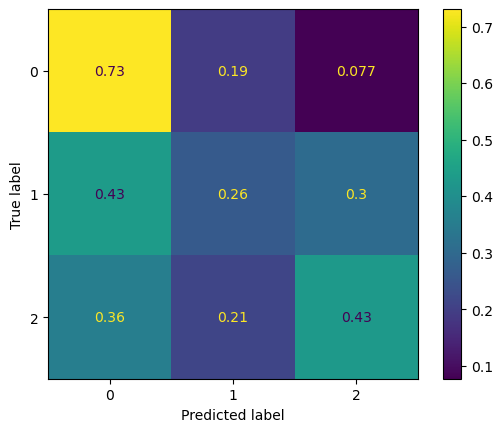

In [846]:
pipe = Pipeline([
    ('std', StandardScaler()),
    ('clf', SVC(**{k.split('__')[1]:v for k,v in results.best_params_.items()}))
     ])

pipe.fit(train[features], train['target_id'])

plot_confusion_matrix(
    pipe,
    X=test[features],
    y_true=test['target_id'],
    normalize='true')

**Pontos**
 - Aqui aparentemente temos resultados se unirmos duas classes (papel e tesoura);
 - A Classe "relaxado" (id 3) está ruim também;
 - Temos que investigar oq está causando os zero values vindos do sinal.
 
**TODO**
 - Repetir com 2 eletrodos (um na mão?)